# Bayesian logistic regression

_Author: Christoph Rahmede_

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Breast-cancer" data-toc-modified-id="Breast-cancer-1">Breast cancer</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Summary-and-score" data-toc-modified-id="Summary-and-score-1.0.1">Summary and score</a></span></li><li><span><a href="#Forest-plot" data-toc-modified-id="Forest-plot-1.0.2">Forest plot</a></span></li><li><span><a href="#Trace-plot" data-toc-modified-id="Trace-plot-1.0.3">Trace plot</a></span></li><li><span><a href="#Divergencies" data-toc-modified-id="Divergencies-1.0.4">Divergencies</a></span></li></ul></li><li><span><a href="#Principal-components" data-toc-modified-id="Principal-components-1.1">Principal components</a></span></li><li><span><a href="#Regularization" data-toc-modified-id="Regularization-1.2">Regularization</a></span></li><li><span><a href="#GLM-model-setup" data-toc-modified-id="GLM-model-setup-1.3">GLM model setup</a></span></li></ul></li><li><span><a href="#Iris-dataset-and-multiple-classes" data-toc-modified-id="Iris-dataset-and-multiple-classes-2">Iris dataset and multiple classes</a></span><ul class="toc-item"><li><span><a href="#Perform-a-train-test-split,-fit-on-the-training-set-and-evaluate-the-model-on-each-set" data-toc-modified-id="Perform-a-train-test-split,-fit-on-the-training-set-and-evaluate-the-model-on-each-set-2.1">Perform a train-test split, fit on the training set and evaluate the model on each set</a></span></li></ul></li></ul></div>

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

warnings.simplefilter('ignore')

In [18]:
import pymc3 as pm
import arviz as az
import theano.tensor as tt

## Breast cancer

We start with some known datasets. We prepare the data with rescaling and fit a default scikit-learn logistic regression model for reference.

In [20]:
from sklearn.datasets import load_breast_cancer

In [21]:
data = load_breast_cancer()

In [22]:
X = data.data
y = data.target

In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
lr = LogisticRegression(C=10**10, solver='lbfgs', max_iter=10000)
lr.fit(Xs, y)
lr.score(Xs, y)

1.0

In [27]:
lr.intercept_, lr.coef_

(array([-1231.41707511]),
 array([[ 6340.09029007,  -418.4400087 ,  2440.243071  , -7134.69928153,
          -204.11530216,  1871.19542195, -2085.52824994,  -747.37122348,
           399.81798259,  -372.30608891, -2171.4295776 ,   144.75444096,
          2081.95547841, -1562.43188047,   205.14233082,  -793.10696557,
          1472.1159865 , -1347.72341176,   560.63561385,  1045.84678959,
          -274.35655024,  -305.84521285, -2873.19527242,  -814.82502867,
          -118.0077374 ,   287.71760134,  -305.34178326,  -511.10145679,
          -932.34634938,  -493.94734279]]))

In [28]:
data.feature_names.shape

(30,)

In [29]:
n = 30
with pm.Model() as model:
    intercept_std = pm.HalfNormal('intercept_std', 10)
    intercept_norm = pm.Normal('intercept_norm', mu=0, sd=1)
    intercept = pm.Deterministic('intercept', intercept_norm*intercept_std)
    beta = pm.Normal('beta', mu=0, sd=20, shape=n)
    mu = pm.Deterministic('mu', intercept+pm.math.dot(Xs[:, :n], beta))
    p = pm.Deterministic('p', pm.invlogit(mu))  # 1/(1+pm.math.exp(-mu)))
    y_hat = pm.Bernoulli('y_hat', p=p, observed=y)

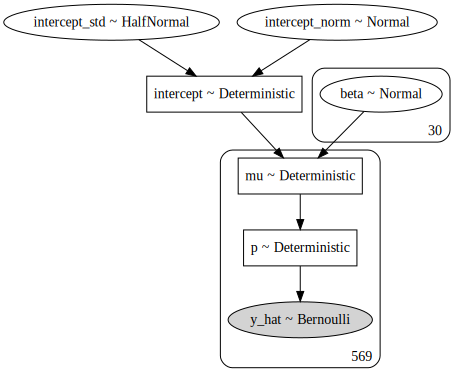

In [30]:
pm.model_to_graphviz(model)

Be prepared that with the original setup the sampling could sometimes crash!

In [15]:
with model:
    trace = pm.sample(2000, nuts_kwargs={'target_accept': 0.95}, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, intercept_norm, intercept_std]
Sampling 2 chains: 100%|██████████| 8000/8000 [02:48<00:00, 47.48draws/s]
There were 565 divergences after tuning. Increase `target_accept` or reparameterize.
There were 644 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


#### Summary and score

In [16]:
pm.summary(trace, varnames=['beta'])

mean         sd  mc_error    hpd_2.5   hpd_97.5        n_eff  \
beta__0   12.995023  15.576631  0.317572 -17.739004  43.382468  2501.076942   
beta__1    0.077234   2.450881  0.070862  -4.825819   4.611148  1168.101934   
beta__2    8.531827  16.400042  0.372840 -23.941921  40.057631  1926.959151   
beta__3   -3.474913  14.867295  0.315131 -30.834802  26.813792  2206.337235   
beta__4   -4.694947   2.698208  0.075219 -10.002787   0.471753  1241.158060   
beta__5   17.196299   7.066319  0.195024   3.850502  31.171414  1291.789456   
beta__6  -16.831558   7.568390  0.210154 -31.890614  -2.430207  1235.565596   
beta__7   -5.821229   6.600991  0.162767 -18.851620   6.807439  1452.281767   
beta__8    2.772481   1.722611  0.041994  -0.654559   6.164705  1391.546636   
beta__9   -2.378725   3.286465  0.077105  -8.360215   4.660955  1453.795985   
beta__10  -8.682647   8.566337  0.222072 -26.233201   7.507799  1284.510577   
beta__11   3.984748   2.071854  0.059724  -0.134392   8.024002  1113.043818   
beta__12   7.112822   6.414898  0.141255  -5.771179  19.425944  2119.674584   
beta__13 -19.583401  12.330693  0.261080 -43.867777   4.064050  2151.651353   
beta__14  -2.359550   2.090498  0.056928  -6.532749   1.554369  1091.241444   
beta__15  -8.811714   4.264174  0.115550 -17.227399  -0.545110  1292.501856   
beta__16  13.035858   4.505112  0.138700   4.706147  22.493587   890.476857   
beta__17 -12.150510   4.169248  0.118945 -20.346625  -4.211024  1203.804845   
beta__18   3.397145   2.219879  0.056163  -0.774360   7.895068  1435.025655   
beta__19  17.156490   5.869746  0.196268   6.544134  29.509803   903.132876   
beta__20 -13.424376  13.483684  0.291542 -39.936001  13.313555  1700.385273   
beta__21  -9.217430   3.281200  0.102129 -15.807502  -3.048696   954.786962   
beta__22  -9.410632  13.834759  0.338758 -36.973922  17.375717  1544.348408   
beta__23 -16.102375  15.306835  0.337509 -45.877310  13.299507  2052.665813   
beta__24   1.997082   2.774863  0.074242  -3.732837   7.268185  1233.381277   
beta__25   6.722441   6.549779  0.157125  -5.609047  20.457586  1536.710486   
beta__26  -6.902816   5.720693  0.150393 -18.224208   4.377165  1393.323570   
beta__27  -1.811999   5.137012  0.108145 -12.240768   8.021463  1815.383974   
beta__28  -6.331508   2.625206  0.063923 -11.694566  -1.379496  1308.864704   
beta__29 -11.443637   4.398034  0.131969 -20.097836  -3.047589  1103.547255   

              Rhat  
beta__0   0.999779  
beta__1   1.000267  
beta__2   0.999867  
beta__3   1.000009  
beta__4   1.000428  
beta__5   1.000135  
beta__6   1.000077  
beta__7   1.002288  
beta__8   1.001009  
beta__9   0.999768  
beta__10  0.999782  
beta__11  0.999757  
beta__12  0.999794  
beta__13  1.000312  
beta__14  1.000419  
beta__15  0.999829  
beta__16  1.000005  
beta__17  0.999789  
beta__18  0.999753  
beta__19  0.999751  
beta__20  0.999798  
beta__21  1.000291  
beta__22  1.001179  
beta__23  0.999802  
beta__24  0.999759  
beta__25  0.999754  
beta__26  1.000933  
beta__27  1.000051  
beta__28  0.999840  
beta__29  0.999939

Even though we had a lot of divergences and the signs of the coefficients have not been determined very precisely in many cases, we do get high accuracy with the mean prediction.

In [17]:
np.mean(y == (trace['p'].mean(axis=0) > 0.5))

0.9912126537785588

#### Forest plot

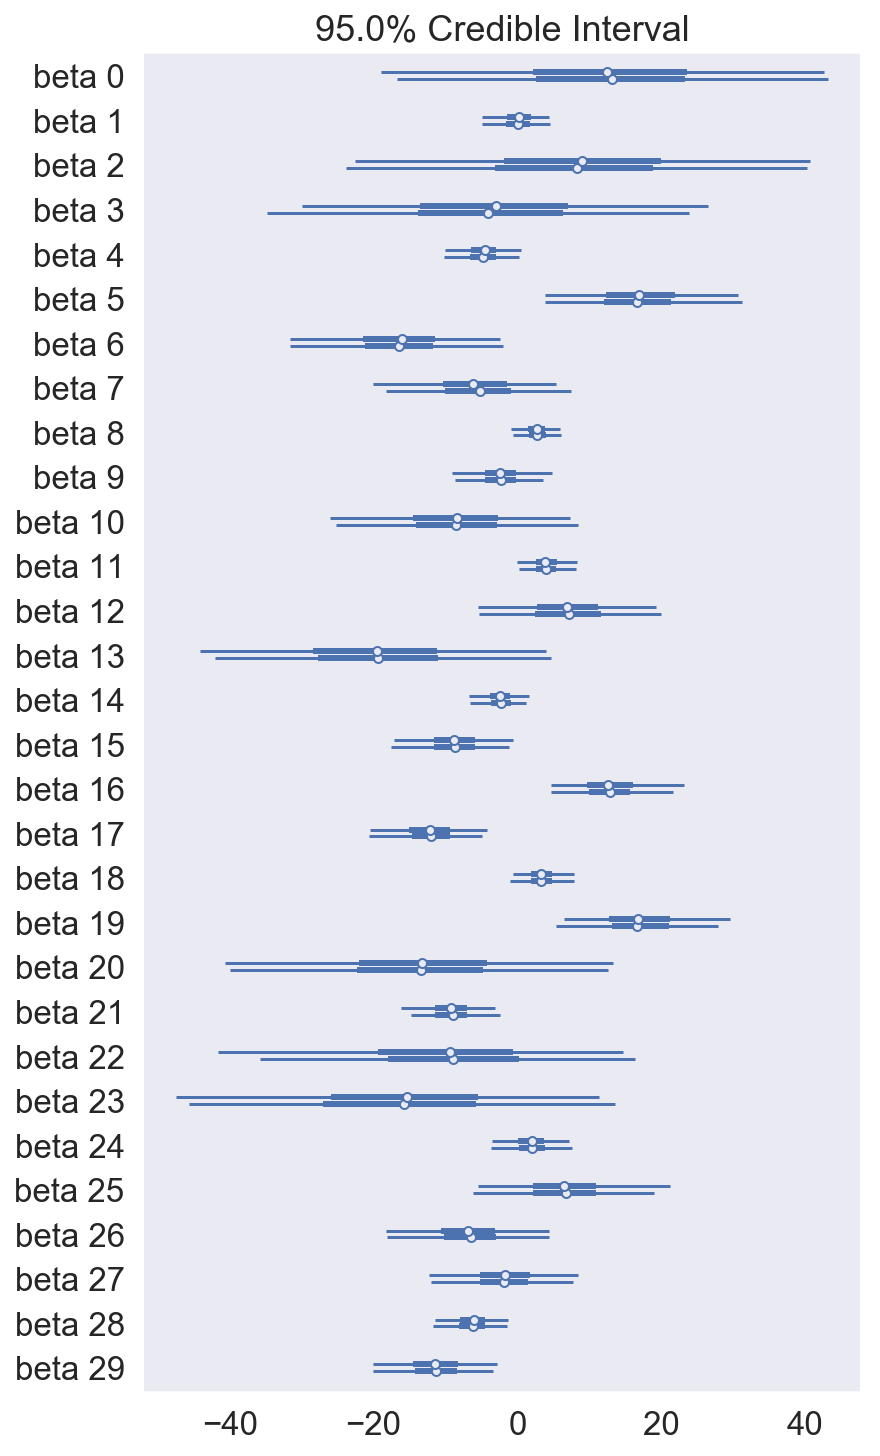

In [18]:
az.plot_forest(trace, var_names=['beta'], credible_interval=0.95)
plt.show()

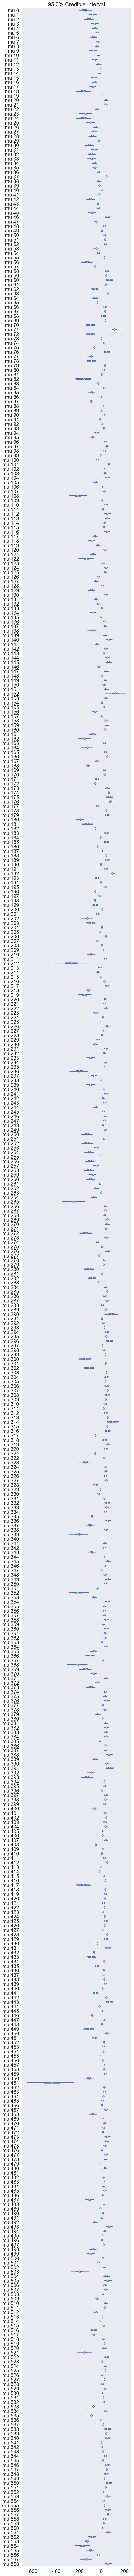

In [19]:
az.plot_forest(trace, var_names=['mu'], credible_interval=0.95)
plt.show()

#### Trace plot

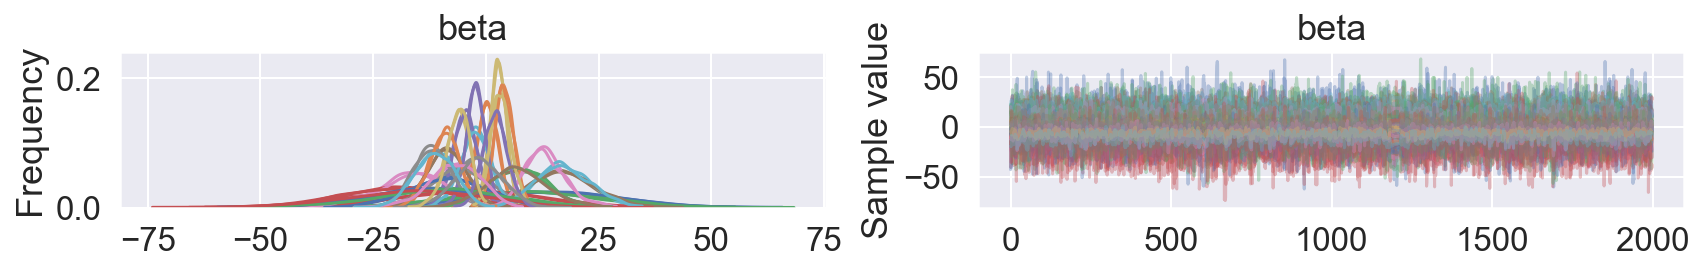

In [20]:
pm.traceplot(trace, varnames=['beta'], grid=True, combined=False)
plt.show()

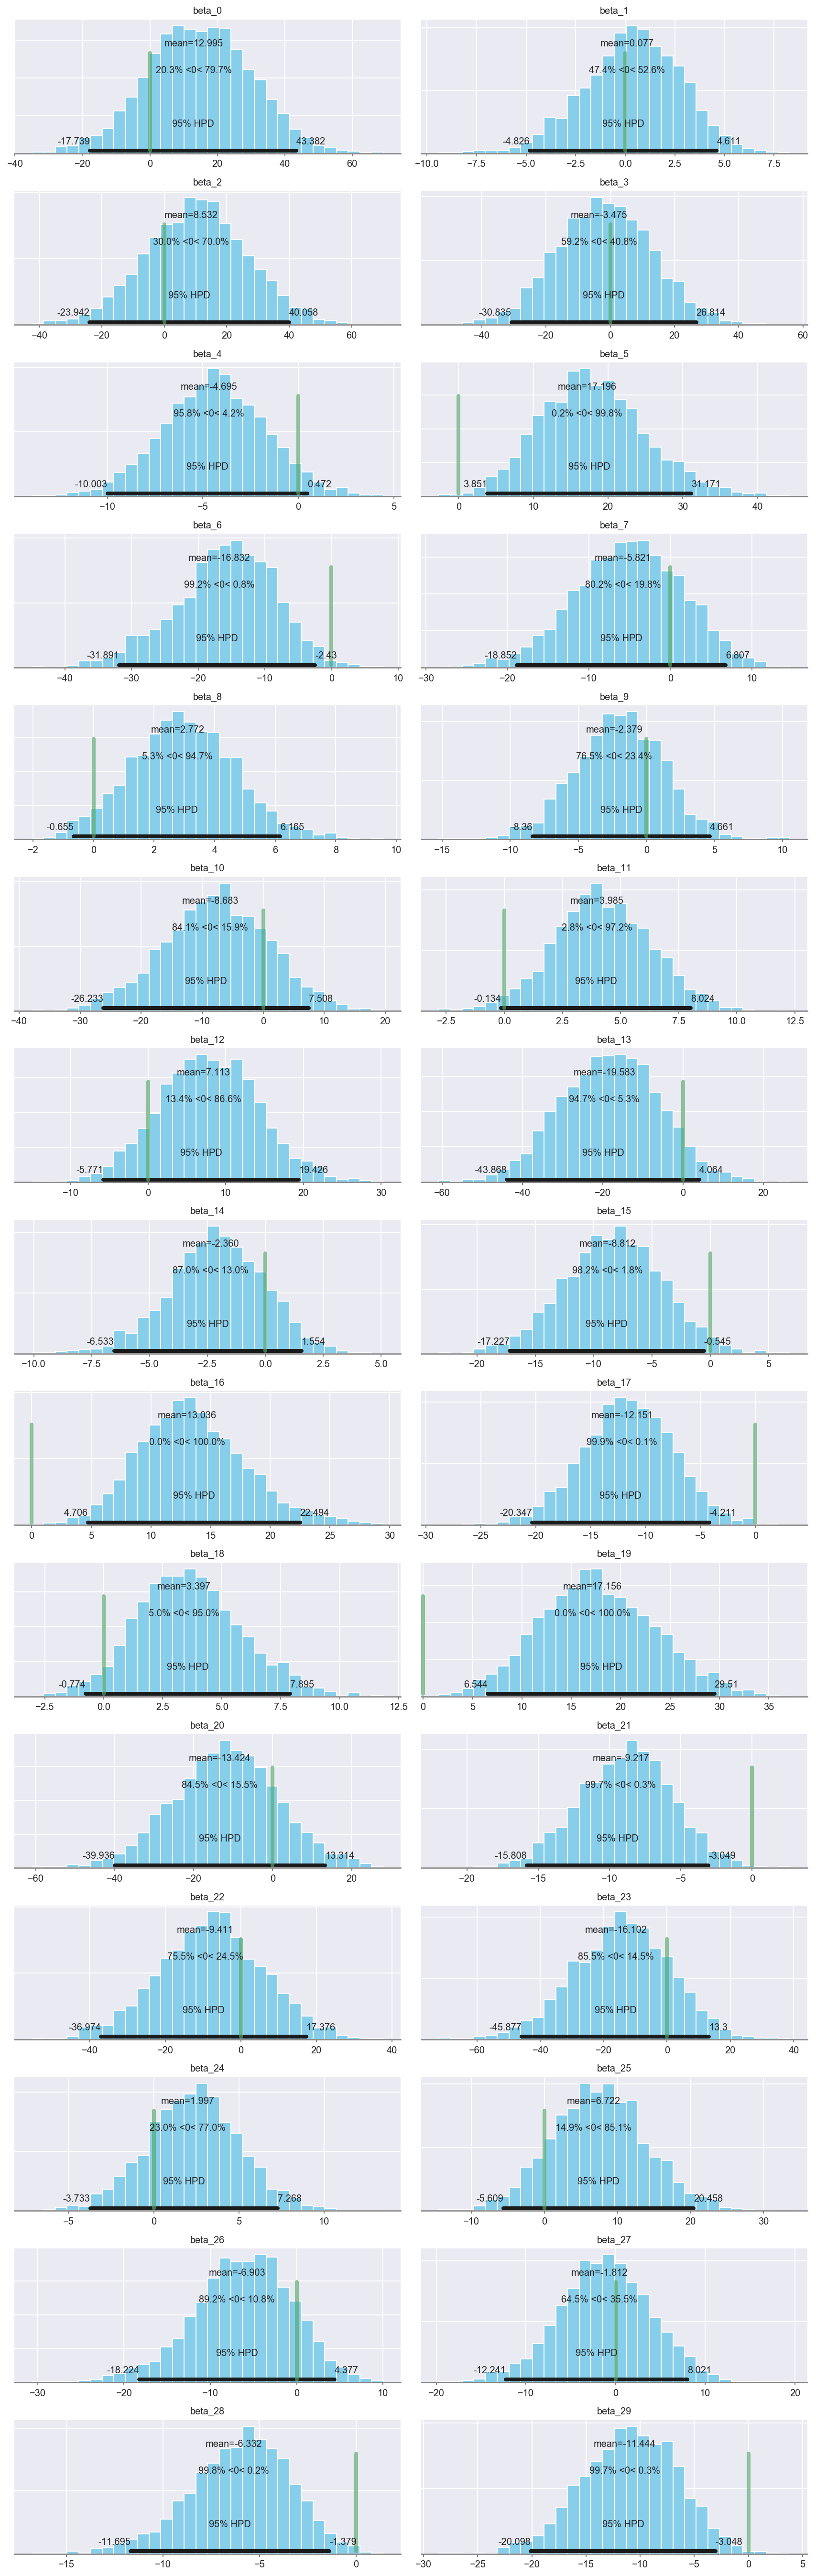

In [21]:
pm.plot_posterior(trace, varnames=['beta'], ref_val=0)
plt.show()

#### Divergencies

Usually, the divergencies cannot simply be ignored. One can ask about which iteration steps lead to divergencies and one could follow up for which parameter combinations problems arise. Here are however simply too many.

In [22]:
trace['diverging'].mean()

0.3025

Arviz indicates the divergences in the trace plot.

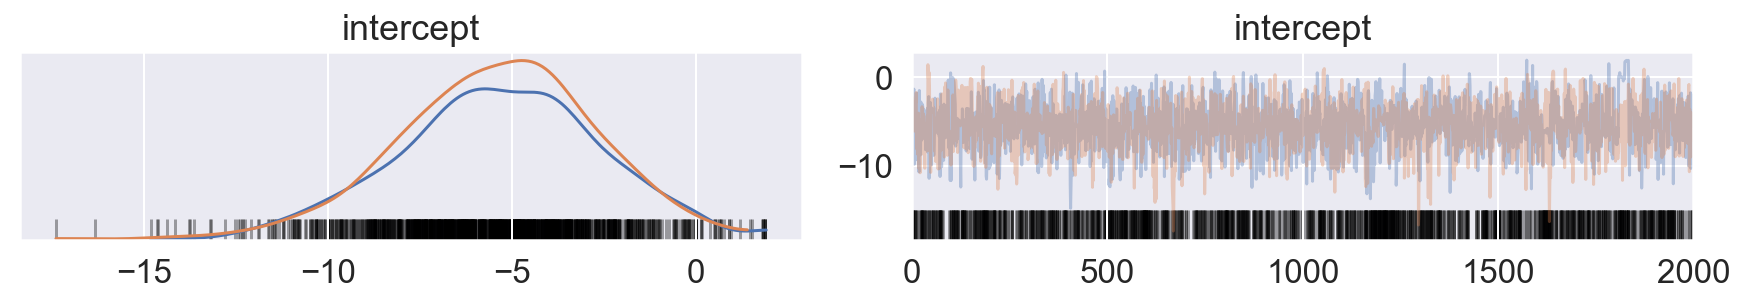

In [23]:
az.plot_trace(trace, var_names=['intercept'])
plt.show()

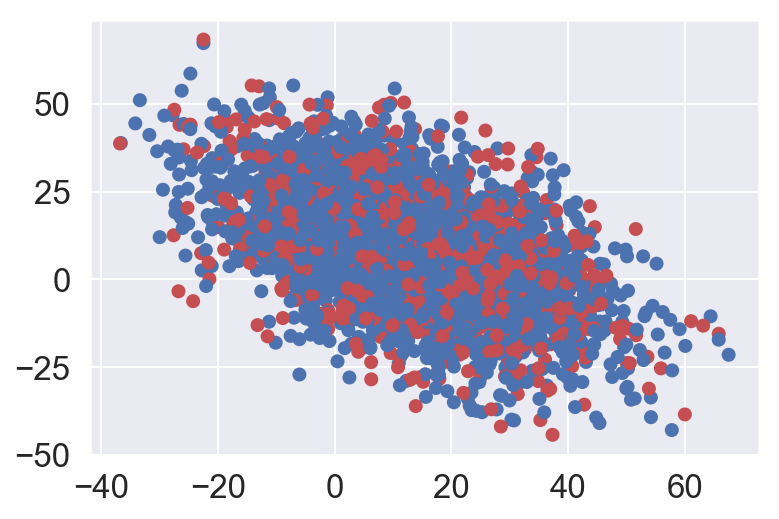

In [24]:
plt.scatter(trace['beta'][:, 0], trace['beta'][:, 2], color=list(
    map(lambda x: 'r' if x else 'b', trace['diverging'])))
plt.show()

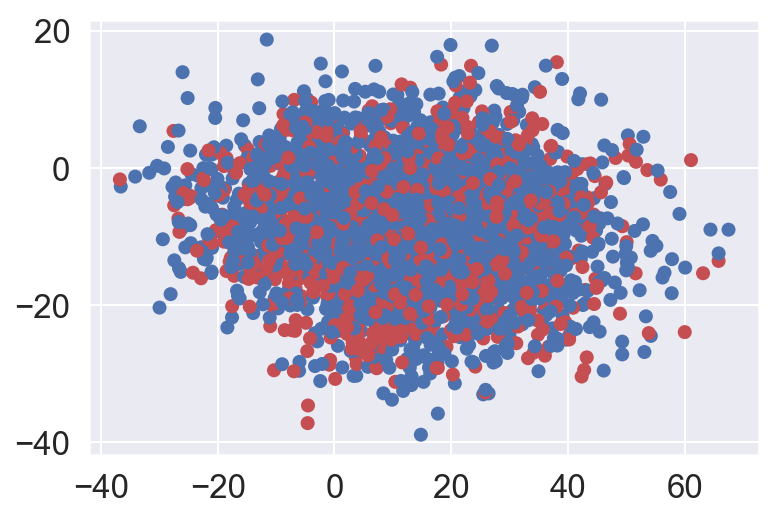

In [25]:
plt.scatter(trace['beta'][:, 0], trace['beta'][:, 10], color=list(
    map(lambda x: 'r' if x else 'b', trace['diverging'])))
plt.show()

Let's investigate where the divergences could stem from, for example by looking at the correlations.

In [26]:
pd.DataFrame(Xs, columns=data.feature_names).corr()

mean radius  mean texture  mean perimeter  mean area  \
mean radius                 1.000000      0.323782        0.997855   0.987357   
mean texture                0.323782      1.000000        0.329533   0.321086   
mean perimeter              0.997855      0.329533        1.000000   0.986507   
mean area                   0.987357      0.321086        0.986507   1.000000   
mean smoothness             0.170581     -0.023389        0.207278   0.177028   
mean compactness            0.506124      0.236702        0.556936   0.498502   
mean concavity              0.676764      0.302418        0.716136   0.685983   
mean concave points         0.822529      0.293464        0.850977   0.823269   
mean symmetry               0.147741      0.071401        0.183027   0.151293   
mean fractal dimension     -0.311631     -0.076437       -0.261477  -0.283110   
radius error                0.679090      0.275869        0.691765   0.732562   
texture error              -0.097317      0.386358       -0.086761  -0.066280   
perimeter error             0.674172      0.281673        0.693135   0.726628   
area error                  0.735864      0.259845        0.744983   0.800086   
smoothness error           -0.222600      0.006614       -0.202694  -0.166777   
compactness error           0.206000      0.191975        0.250744   0.212583   
concavity error             0.194204      0.143293        0.228082   0.207660   
concave points error        0.376169      0.163851        0.407217   0.372320   
symmetry error             -0.104321      0.009127       -0.081629  -0.072497   
fractal dimension error    -0.042641      0.054458       -0.005523  -0.019887   
worst radius                0.969539      0.352573        0.969476   0.962746   
worst texture               0.297008      0.912045        0.303038   0.287489   
worst perimeter             0.965137      0.358040        0.970387   0.959120   
worst area                  0.941082      0.343546        0.941550   0.959213   
worst smoothness            0.119616      0.077503        0.150549   0.123523   
worst compactness           0.413463      0.277830        0.455774   0.390410   
worst concavity             0.526911      0.301025        0.563879   0.512606   
worst concave points        0.744214      0.295316        0.771241   0.722017   
worst symmetry              0.163953      0.105008        0.189115   0.143570   
worst fractal dimension     0.007066      0.119205        0.051019   0.003738   

                         mean smoothness  mean compactness  mean concavity  \
mean radius                     0.170581          0.506124        0.676764   
mean texture                   -0.023389          0.236702        0.302418   
mean perimeter                  0.207278          0.556936        0.716136   
mean area                       0.177028          0.498502        0.685983   
mean smoothness                 1.000000          0.659123        0.521984   
mean compactness                0.659123          1.000000        0.883121   
mean concavity                  0.521984          0.883121        1.000000   
mean concave points             0.553695          0.831135        0.921391   
mean symmetry                   0.557775          0.602641        0.500667   
mean fractal dimension          0.584792          0.565369        0.336783   
radius error                    0.301467          0.497473        0.631925   
texture error                   0.068406          0.046205        0.076218   
perimeter error                 0.296092          0.548905        0.660391   
area error                      0.246552          0.455653        0.617427   
smoothness error                0.332375          0.135299        0.098564   
compactness error               0.318943          0.738722        0.670279   
concavity error                 0.248396          0.570517        0.691270   
concave points error            0.380676          0.642262        0.683260   
symmetry error                 

### Principal components

There are strong correlations among the predictors. Maybe principal components could help to get rid of them.


In [27]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(Xs)

pca.explained_variance_ratio_

array([4.42720256e-01, 1.89711820e-01, 9.39316326e-02, 6.60213492e-02,
       5.49576849e-02, 4.02452204e-02, 2.25073371e-02, 1.58872380e-02,
       1.38964937e-02, 1.16897819e-02, 9.79718988e-03, 8.70537901e-03,
       8.04524987e-03, 5.23365745e-03, 3.13783217e-03, 2.66209337e-03,
       1.97996793e-03, 1.75395945e-03, 1.64925306e-03, 1.03864675e-03,
       9.99096464e-04, 9.14646751e-04, 8.11361259e-04, 6.01833567e-04,
       5.16042379e-04, 2.72587995e-04, 2.30015463e-04, 5.29779290e-05,
       2.49601032e-05, 4.43482743e-06])

In [28]:
import scikitplot as skplt

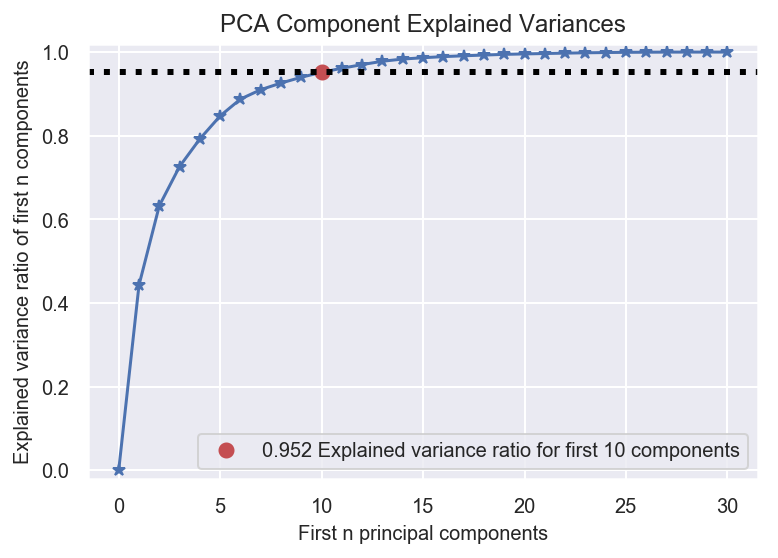

In [29]:
skplt.decomposition.plot_pca_component_variance(
    pca, target_explained_variance=0.95)
plt.show()

In [30]:
n = 10
with pm.Model() as model_pca:
    intercept_mean = pm.Normal('intercept_mean', 0.0, sd=1)
    intercept_std = pm.HalfNormal('intercept_std', 10)
    beta_std = pm.HalfNormal('beta_std', 10, shape=n)
    intercept_norm = pm.Normal('intercept_norm', mu=intercept_mean, sd=1)
    intercept = pm.Deterministic('intercept', intercept_norm*intercept_std)
    mean = pm.Normal('mean', 0.0, sd=1, shape=n)
    beta_norm = pm.Normal('beta_norm', mu=mean, sd=1, shape=n)
    beta = pm.Deterministic('beta', beta_norm*beta_std)
    mu = pm.Deterministic('mu', intercept+pm.math.dot(X_pca[:, :n], beta))
    p = pm.Deterministic('p', pm.invlogit(mu))
    y_hat = pm.Bernoulli('y_hat', logit_p=mu, observed=y)

In [31]:
with model_pca:
    trace_pca = pm.sample(2000, tune=1000, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_norm, mean, intercept_norm, beta_std, intercept_std, intercept_mean]
Sampling 2 chains: 100%|██████████| 6000/6000 [02:31<00:00, 22.63draws/s]
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


We get good scores and less divergencies, but the problem has not yet been fully addressed.

In [32]:
np.mean(y == (trace_pca['p'].mean(axis=0) > 0.5))

0.9824253075571178

### Regularization 

The result of the strong correlations we can also see if we run scikit-learn's logistic regression without regularization.

In [33]:
lr = LogisticRegression(C=10**10, solver='lbfgs', max_iter=10000)
lr.fit(Xs, y)
lr.score(Xs, y)

1.0

In [34]:
lr.intercept_, lr.coef_

(array([-1121.92852964]),
 array([[ 6050.01451333,  -562.2192149 ,  2472.87547845, -7113.93109466,
          -230.98194895,  1986.28062302, -2126.45588413,  -569.91812182,
           383.89869357,  -439.54854046, -2392.36828451,    67.13726387,
          1856.38716125,  -797.16530339,   171.17178325,  -980.69763387,
          1416.24087693, -1281.82844367,   641.55644715,  1295.2434457 ,
          -659.76535176,  -156.12264891, -2768.15575964,  -580.23482401,
          -179.62580428,   322.73504056,  -240.88794193,  -544.67902962,
          -963.22477679,  -550.80666908]]))

Apparently, regularization is exactly what we were missing.

In [35]:
n = 30
with pm.Model() as model_reg:
    intercept_std = pm.HalfNormal('intercept_std', 3)
    intercept_norm = pm.Normal('intercept_norm', mu=0, sd=1)
    intercept = pm.Deterministic('intercept', intercept_norm*intercept_std)
    beta = pm.Normal('beta', mu=0, sd=1, shape=n)
    mu = pm.Deterministic('mu', intercept+pm.math.dot(Xs[:, :n], beta))
    p = pm.Deterministic('p', pm.invlogit(mu))  # 1/(1+pm.math.exp(-mu)))
    y_hat = pm.Bernoulli('y_hat', p=p, observed=y)

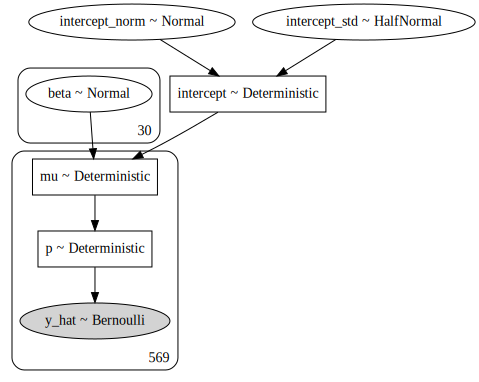

In [36]:
pm.model_to_graphviz(model_reg)

In [37]:
with model_reg:
    trace_reg = pm.sample(5000, tune=2000, nuts_kwargs={
                          'target_accept': 0.95, 'max_treedepth': 20})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, intercept_norm, intercept_std]
Sampling 2 chains: 100%|██████████| 14000/14000 [01:11<00:00, 195.14draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Now the divergencies are nearly gone. You can try if you can get rid even of the last one.

In [38]:
pm.summary(trace_reg, varnames=['beta'])

mean        sd  mc_error   hpd_2.5  hpd_97.5         n_eff  \
beta__0  -0.457773  0.888198  0.008277 -2.218733  1.262233  11099.409532   
beta__1  -0.468307  0.557802  0.005478 -1.578058  0.622059   8828.422947   
beta__2  -0.448183  0.896088  0.007764 -2.301007  1.222257  13553.855821   
beta__3  -0.556121  0.918625  0.008201 -2.384713  1.219145  11365.450849   
beta__4  -0.224689  0.611549  0.006877 -1.475628  0.927427   8622.352795   
beta__5   0.591878  0.792728  0.008090 -0.909094  2.192903   9864.327210   
beta__6  -0.970638  0.820813  0.007759 -2.564482  0.644953  10503.396162   
beta__7  -1.087737  0.821483  0.007887 -2.710489  0.490771  11483.528809   
beta__8   0.102618  0.514814  0.005705 -0.962419  1.062908   8344.954546   
beta__9   0.435377  0.686900  0.007307 -0.951778  1.740334   9492.829676   
beta__10 -1.446388  0.789383  0.009506 -2.966018  0.100921   7848.428951   
beta__11  0.331961  0.500427  0.004441 -0.616497  1.335929   9558.121982   
beta__12 -0.798744  0.797447  0.008385 -2.342634  0.797429   8969.016537   
beta__13 -1.186535  0.919200  0.009323 -2.957657  0.593690  10514.202602   
beta__14 -0.443541  0.464582  0.004920 -1.370074  0.448102   8455.949415   
beta__15  0.736660  0.662292  0.007286 -0.578012  2.002573   9412.427110   
beta__16  0.326063  0.627722  0.006613 -0.865931  1.568582   8421.419207   
beta__17 -0.316670  0.668056  0.007130 -1.673502  0.918719   8838.103450   
beta__18  0.297937  0.524452  0.006328 -0.769806  1.292737   8440.293347   
beta__19  0.805067  0.694299  0.006966 -0.507303  2.181306  11397.366610   
beta__20 -1.138061  0.937431  0.008296 -2.888238  0.730014  12785.265863   
beta__21 -1.495007  0.655199  0.006934 -2.768786 -0.196163   7530.429700   
beta__22 -0.904538  0.907736  0.008665 -2.733835  0.837120  11601.449983   
beta__23 -1.140990  0.922793  0.008181 -2.994999  0.605656  11220.408744   
beta__24 -0.725802  0.622594  0.007205 -1.898049  0.560043   8112.292293   
beta__25 -0.017480  0.773061  0.007750 -1.515465  1.491170  10035.015989   
beta__26 -0.993386  0.753293  0.007389 -2.413794  0.538843   9834.534454   
beta__27 -1.014412  0.784184  0.007657 -2.573410  0.484348  10263.144788   
beta__28 -1.054176  0.552267  0.006482 -2.117737  0.047668   7267.225383   
beta__29 -0.528702  0.719817  0.007412 -1.917582  0.895517   9265.919820   

              Rhat  
beta__0   0.999903  
beta__1   1.000157  
beta__2   0.999933  
beta__3   0.999906  
beta__4   0.999904  
beta__5   0.999928  
beta__6   1.000258  
beta__7   1.000115  
beta__8   0.999903  
beta__9   0.999902  
beta__10  0.999930  
beta__11  0.999933  
beta__12  0.999921  
beta__13  0.999901  
beta__14  1.000041  
beta__15  1.000134  
beta__16  0.999905  
beta__17  0.999913  
beta__18  1.000215  
beta__19  1.000060  
beta__20  0.999914  
beta__21  0.999902  
beta__22  0.999970  
beta__23  0.999921  
beta__24  0.999927  
beta__25  1.000130  
beta__26  1.000066  
beta__27  1.000022  
beta__28  1.000215  
beta__29  0.999938

In [43]:
trace_reg['diverging'].sum()

1

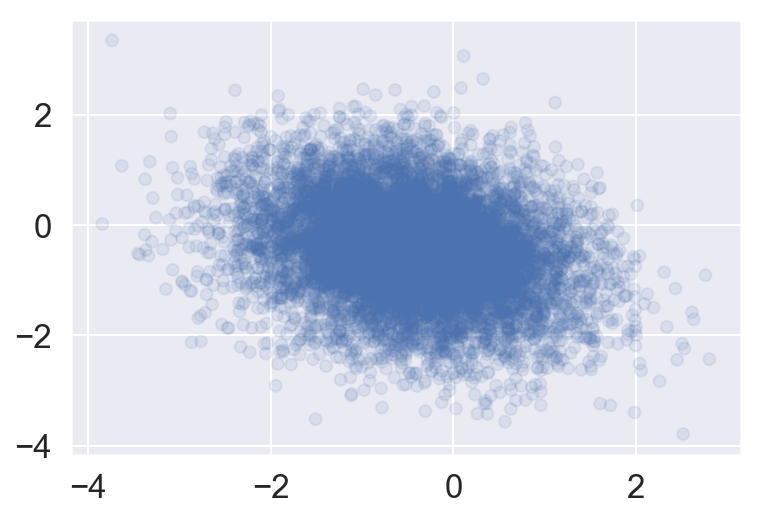

In [44]:
plt.scatter(trace_reg['beta'][:, 0], trace_reg['beta'][:, 2], color=list(
    map(lambda x: 'r' if x else 'b', trace_reg['diverging'])), alpha=0.1)
plt.show()

In [45]:
np.mean(y == (trace_reg['p'].mean(axis=0) > 0.5))

0.9876977152899824

Coefficients are of controlled size though still with a lot of uncertainty.

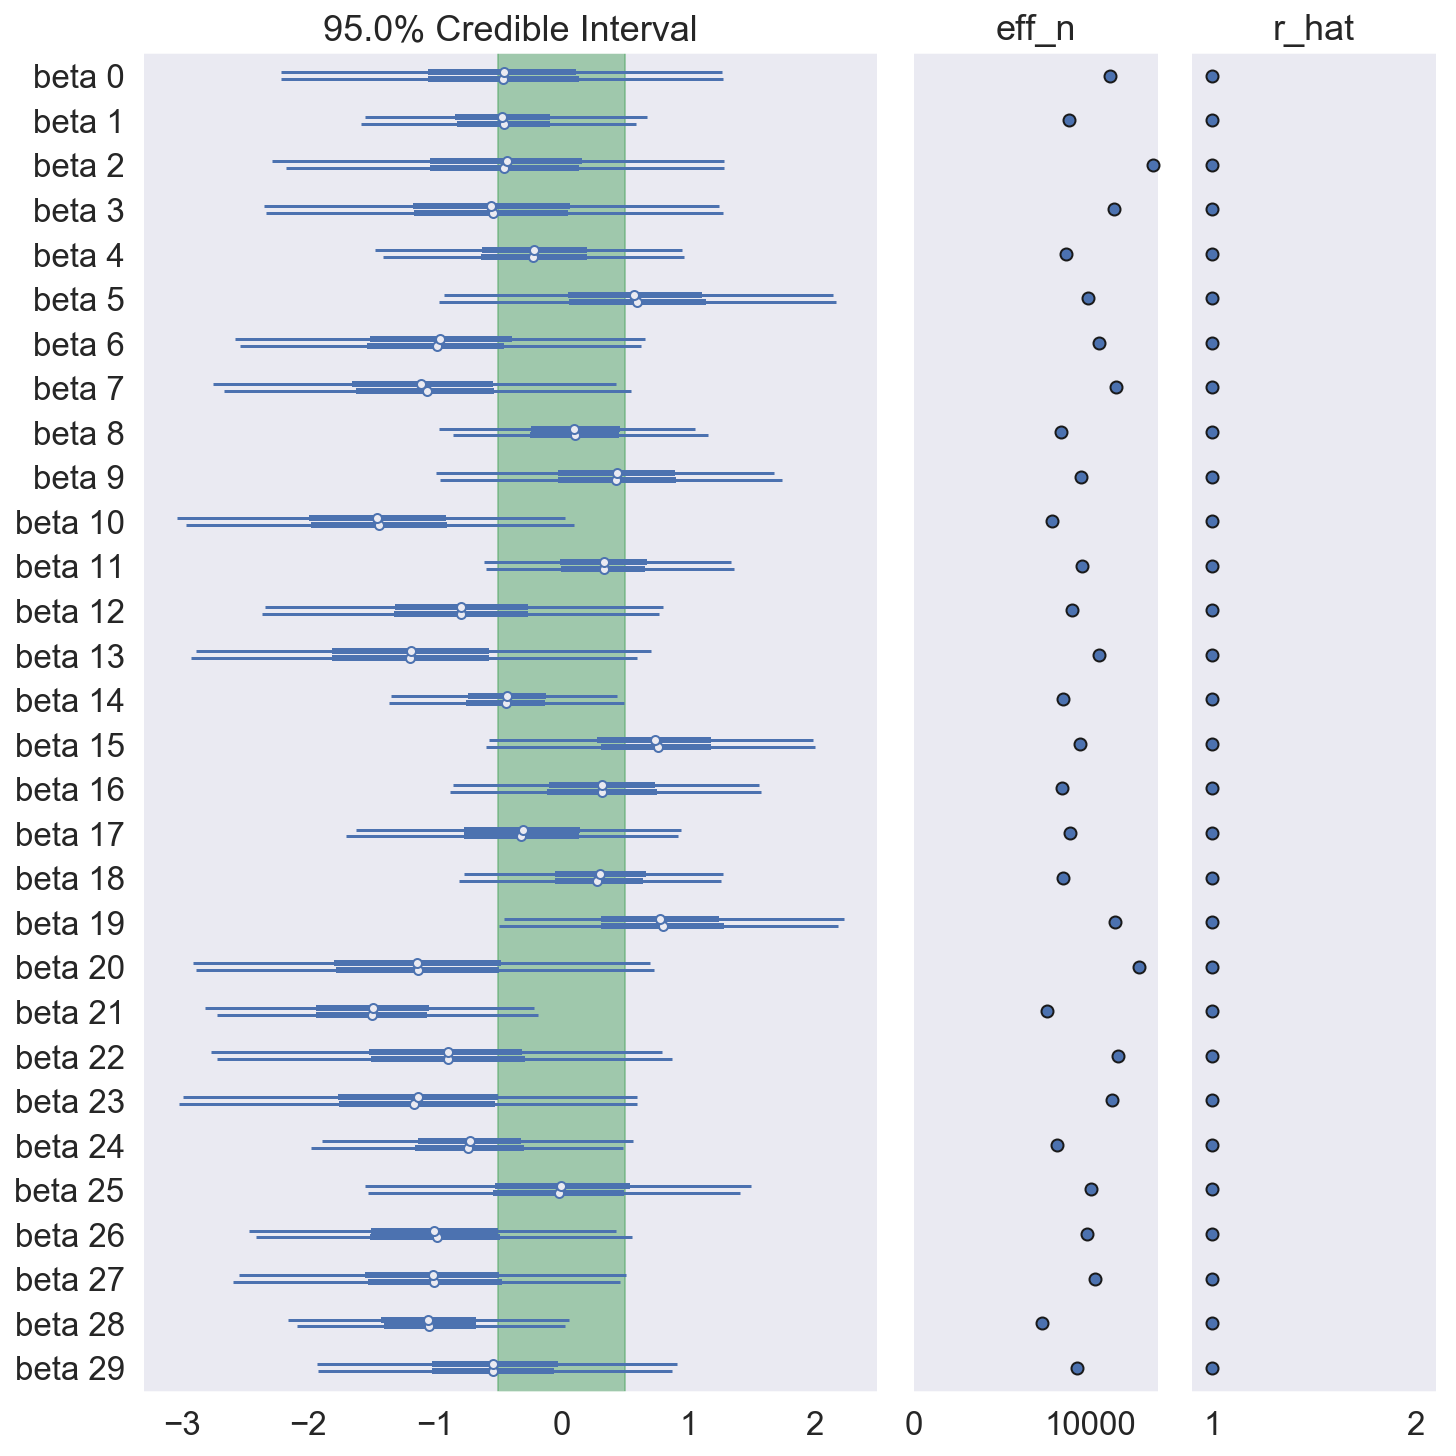

In [46]:
az.plot_forest(trace_reg, var_names=[
               'beta'], rope=[-0.5, 0.5], credible_interval=0.95, eff_n=True, r_hat=True)
plt.show()

### GLM model setup

It is possible to run logistic regression with the GLM syntax by specifying `family=pm.glm.families.Binomial()`. The problems remain the same, and with the default priors it takes a very long time to run (if successful at all).

In [47]:
# with pm.Model() as glm:

# labels are required to create keys for the variables in the trace dictionaries
#    pm.glm.GLM(x=Xs,y=y,labels=data.feature_names,family=pm.glm.families.Binomial())
#    trace_glm = pm.sample(1000,tune=1000)

In [48]:
#df = pd.DataFrame(Xs,columns=data.feature_names)
#df.columns = [col.replace(' ','_') for col in df.columns]
#df['target'] = y

In [49]:
#formula = 'target' + ' ~ ' + ('+').join([col for col in df.columns if col!='target'])
# formula

In [50]:
# with pm.Model() as logistic_model:
#    pm.glm.GLM.from_formula(formula, df, family=pm.glm.families.Binomial())
#    trace_logistic_model = pm.sample(2000, chains=1, tune=1000)

## Iris dataset and multiple classes

The generalization to multiple classes is straight-forward. To formulate the one-versus-rest approach we only have to enhance the shape of intercept and coefficients, and we need to use the softmax and the categorical distribution.

In [8]:
from sklearn.datasets import load_iris

In [42]:
data = load_iris()

In [43]:
X = data.data
y = data.target

In [44]:
from sklearn.preprocessing import StandardScaler

In [45]:
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

In [46]:
lr = LogisticRegression(C=10**10, solver='lbfgs', multi_class='ovr')
lr.fit(Xs, y)
lr.score(Xs, y)

0.98

In [47]:
lr.intercept_, lr.coef_

(array([-10.83493702,  -1.0007062 , -20.10133916]),
 array([[ -1.61458533,   4.63184353, -10.43813993,  -9.62715982],
        [ -0.2024409 ,  -1.21483057,   2.31113275,  -2.11061817],
        [ -2.0344684 ,  -2.90222848,  16.58946986,  13.89172339]]))

In [48]:
from theano import shared

predictors_shared = shared(Xs)
outcome_shared = shared(y)

In [49]:
with pm.Model() as model_i:
    intercept = pm.Normal('intercept', mu=0, sd=10, shape=3)
    beta = pm.Normal('beta', mu=0, sd=10, shape=(4, 3))
    mu = pm.Deterministic('mu', intercept+pm.math.dot(predictors_shared, beta))
    p = pm.Deterministic('p', tt.nnet.softmax(mu))
    y_hat = pm.Categorical('y_hat', p=p, observed=outcome_shared)

/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [50]:
with model_i:
    trace_i = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, intercept]
Sampling 4 chains:   0%|          | 0/10000 [00:00<?, ?draws/s]/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/anaconda3/lib/pytho

In [51]:
from scipy.stats import mode

In [52]:
preds = pm.sample_posterior_predictive(trace_i, model=model_i, samples=1000)
predictions = mode(preds['y_hat']).mode.ravel()
np.mean(np.isclose(y, predictions))

100%|██████████| 1000/1000 [00:15<00:00, 63.37it/s]


0.98

In [53]:
az.plot_forest(trace_i, var_names=[
               'intercept', 'beta'], eff_n=True, r_hat=True)
plt.show()

TypeError: plot_forest() got an unexpected keyword argument 'eff_n'

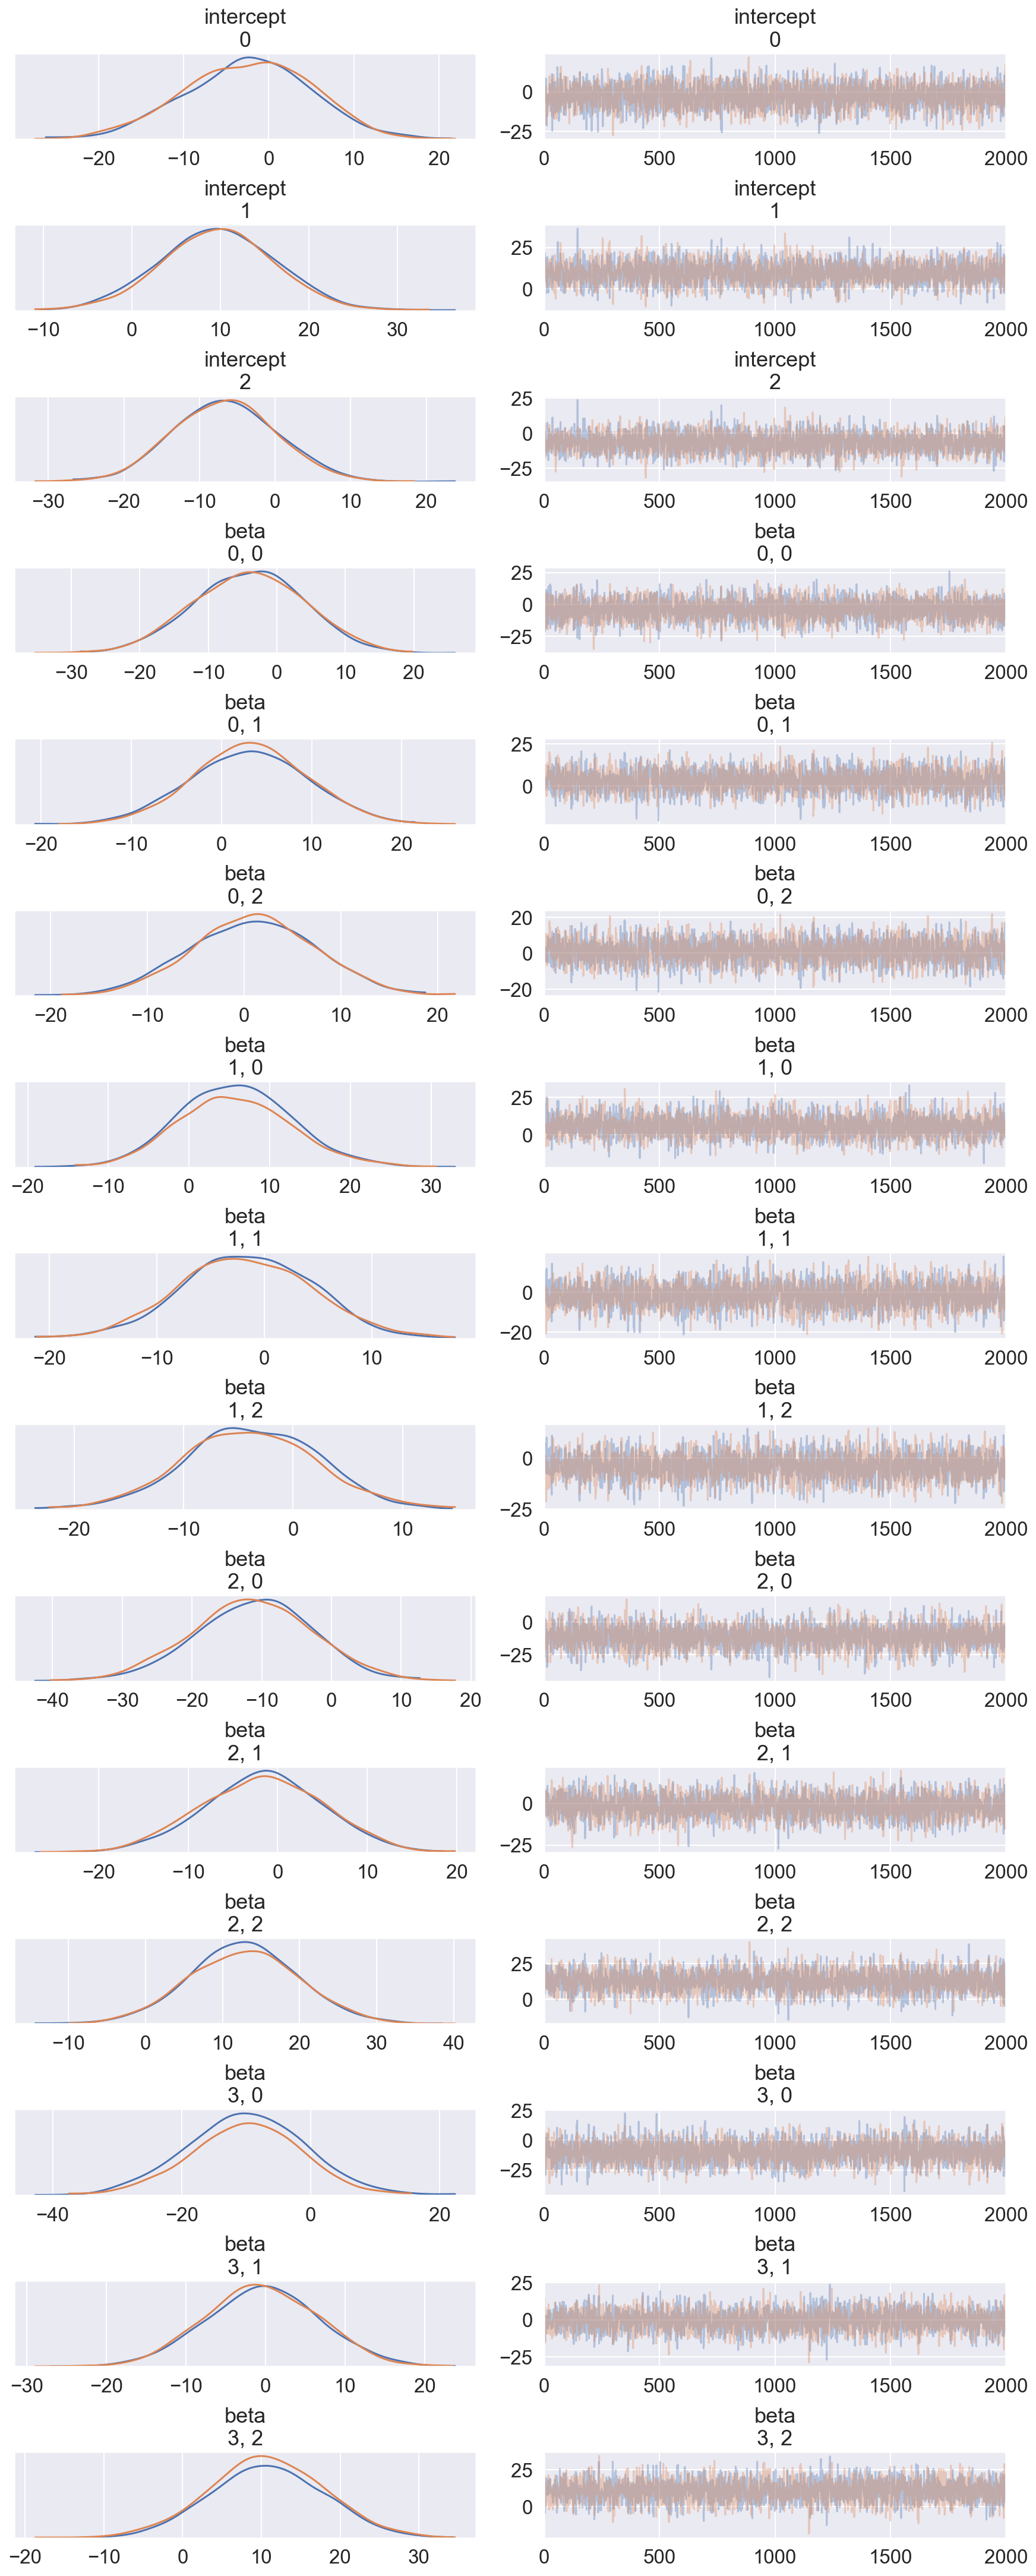

In [68]:
az.plot_trace(trace_i, var_names=['intercept', 'beta'])
plt.show()

### Perform a train-test split, fit on the training set and evaluate the model on each set

In [69]:
from sklearn.model_selection import train_test_split

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    Xs, y, test_size=0.2, stratify=y, random_state=1)

In [71]:
from theano import shared

predictors_shared = shared(X_train)
outcome_shared = shared(y_train)

In [72]:
with pm.Model() as model_train:
    intercept = pm.Normal('intercept', mu=0, sd=10, shape=3)
    beta = pm.Normal('beta', mu=0, sd=10, shape=[4, 3])
    mu = pm.Deterministic('mu', intercept+pm.math.dot(predictors_shared, beta))
    p = pm.Deterministic('p', tt.nnet.softmax(mu))
    y_hat = pm.Categorical('y_hat', p=p, observed=outcome_shared)

In [74]:
with model_train:
    trace_train = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, intercept]
Sampling 2 chains: 100%|██████████| 6000/6000 [01:11<00:00, 84.35draws/s] 


In [75]:
from scipy.stats import mode

In [76]:
preds = pm.sample_posterior_predictive(
    trace_train, model=model_train, samples=1000)
predictions = mode(preds['y_hat']).mode.ravel()
np.mean(np.isclose(y_train, predictions))

100%|██████████| 1000/1000 [00:16<00:00, 59.42it/s]


0.9833333333333333

In [77]:
predictors_shared.set_value(X_test)
outcome_shared.set_value(y_test)

In [78]:
predictors_shared.get_value().shape

(30, 4)

In [79]:
preds = pm.sample_posterior_predictive(
    trace_train, model=model_train, samples=1000)
predictions = mode(preds['y_hat']).mode.ravel()
np.mean(np.isclose(y_test, predictions))

100%|██████████| 1000/1000 [00:11<00:00, 79.06it/s]


1.0